# TP2 - Fondamentaux de l'apprentissage automatique

Executed on Colab

## Pre-execution

### Verify GPU is available

In [1]:
!nvidia-smi

Fri Nov 15 16:01:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### pip installation

In [2]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00


In [3]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==24.10.* dask-cudf-cu12==24.10.* cuml-cu12==24.10.* \
    cugraph-cu12==24.10.* nx-cugraph-cu12==24.10.* cuspatial-cu12==24.10.* \
    cuproj-cu12==24.10.* cuxfilter-cu12==24.10.* cucim-cu12==24.10.* \
    pylibraft-cu12==24.10.* raft-dask-cu12==24.10.* cuvs-cu12==24.10.* \
    nx-cugraph-cu12==24.10.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.5/915.5 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.9/196.9 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.6/836.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Imports

In [4]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

# Only CPU
from sklearn.ensemble import RandomForestClassifier as RFC

# GPU-accelerated
from cuml.manifold import TSNE as cumlTSNE
from cuml.manifold import UMAP as cumlUMAP



### Load datas

In [5]:
print("1. Chargement des données...")
columns = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area1",
    *[f"Soil_Type_{i}" for i in range(1, 40)],
    "Cover_Type"
]

print(columns)

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header=None, names=columns)
data = data.sample(n=20000, random_state=42)
print(data.shape)


1. Chargement des données...
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Cover_Type']
(20000, 51)


### Split datas

In [6]:
X=data.drop('Cover_Type', axis=1)
y=data['Cover_Type']

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize datas

In [7]:
# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fonctions

In [8]:
custom_cmap = ListedColormap(plt.cm.tab10.colors[:7])

# Fonction de visualisation
def visualize_embeddings(X, y, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap, s=1)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [9]:
# Function to evaluate the model
def evaluate(rfc, X_test, y_test):

    y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred))

In [10]:
# convert second to mm:ss

def convert(seconds):
    minutes = seconds // 60
    seconds %= 60
    return "%02d:%02d" % (minutes, seconds)

## Computing

In [11]:
ros = RandomOverSampler(random_state=42)
X_train_scaled_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)

In [12]:
adasyn = ADASYN(random_state=42)
X_train_scaled_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

In [13]:
smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

### Random Over Sampler

In [14]:
# Compute T-SNE (GPU)

time_tsne_ros = time()

tsne_ros = cumlTSNE(n_components=2, random_state=42)
X_tsne_ros = tsne_ros.fit_transform(X_train_scaled_ros)

time_tsne_ros = time() - time_tsne_ros


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [16:05:17.744631] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [15]:
# Compute UMAP (GPU)

time_umap_ros = time()

umap_ros = cumlUMAP(n_components=2, random_state=42)
X_umap_ros = umap_ros.fit_transform(X_train_scaled_ros)

time_umap_ros = time() - time_umap_ros

In [16]:
# Compute Random Forest Classifier

time_rfc_ros = time()

rfc_ros = RFC(n_estimators=100, random_state=42)
rfc_ros.fit(X_train_scaled_ros, y_train_ros)

time_rfc_ros = time() - time_rfc_ros

### ADASYN

In [17]:
# Compute T-SNE (GPU)

time_tsne_adasyn = time()

tsne_adasyn = cumlTSNE(n_components=2, random_state=42)
X_tsne_adasyn = tsne_adasyn.fit_transform(X_train_scaled_adasyn)

time_tsne_adasyn = time() - time_tsne_adasyn

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [16:05:35.000635] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [18]:
# Compute UMAP (GPU)

time_umap_adasyn = time()

umap_adasyn = cumlUMAP(n_components=2, random_state=42)
X_umap_adasyn = umap_adasyn.fit_transform(X_train_scaled_adasyn)

time_umap_adasyn = time() - time_umap_adasyn

In [19]:
# Compute Random Forest Classifier

time_rfc_adasyn = time()

rfc_adasyn = RFC(n_estimators=100, random_state=42)
rfc_adasyn.fit(X_train_scaled_adasyn, y_train_adasyn)

time_rfc_adasyn = time() - time_rfc_adasyn

### Smote

In [20]:
# Compute T-SNE (GPU)

time_tsne_smote = time()

tsne_smote = cumlTSNE(n_components=2, random_state=42)
X_tsne_smote = tsne_smote.fit_transform(X_train_scaled_smote)

time_tsne_smote = time() - time_tsne_smote

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [16:05:49.720752] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [21]:
# Compute UMAP (GPU)

time_umap_smote = time()

umap_smote = cumlUMAP(n_components=2, random_state=42)
X_umap_smote = umap_smote.fit_transform(X_train_scaled_smote)

time_umap_smote = time() - time_umap_smote

In [22]:
# Compute Random Forest Classifier

time_rfc_smote = time()

rfc_smote = RFC(n_estimators=100, random_state=42)
rfc_smote.fit(X_train_scaled_smote, y_train_smote)

time_rfc_smote = time() - time_rfc_smote

## Results

### Speed comparison

In [23]:
print("---- Random Over Sampling ----")
print(f"TSNE: {convert(time_tsne_ros)}")
print(f"UMAP: {convert(time_umap_ros)}")
print(f"RFC: {convert(time_rfc_ros)}")
print("---- ADASYN ----")
print(f"TSNE: {convert(time_tsne_adasyn)}")
print(f"UMAP: {convert(time_umap_adasyn)}")
print(f"RFC: {convert(time_rfc_adasyn)}")
print("---- SMOTE ----")
print(f"TSNE: {convert(time_tsne_smote)}")
print(f"UMAP: {convert(time_umap_smote)}")
print(f"RFC: {convert(time_rfc_smote)}")

---- Random Over Sampling ----
TSNE: 00:06
UMAP: 00:03
RFC: 00:09
---- ADASYN ----
TSNE: 00:02
UMAP: 00:00
RFC: 00:12
---- SMOTE ----
TSNE: 00:02
UMAP: 00:00
RFC: 00:11


### Random Over Sampling

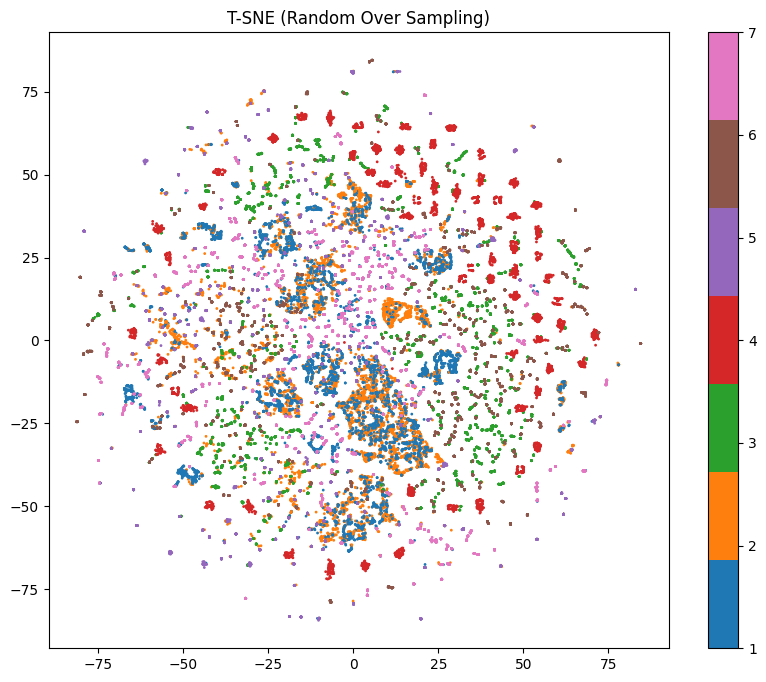

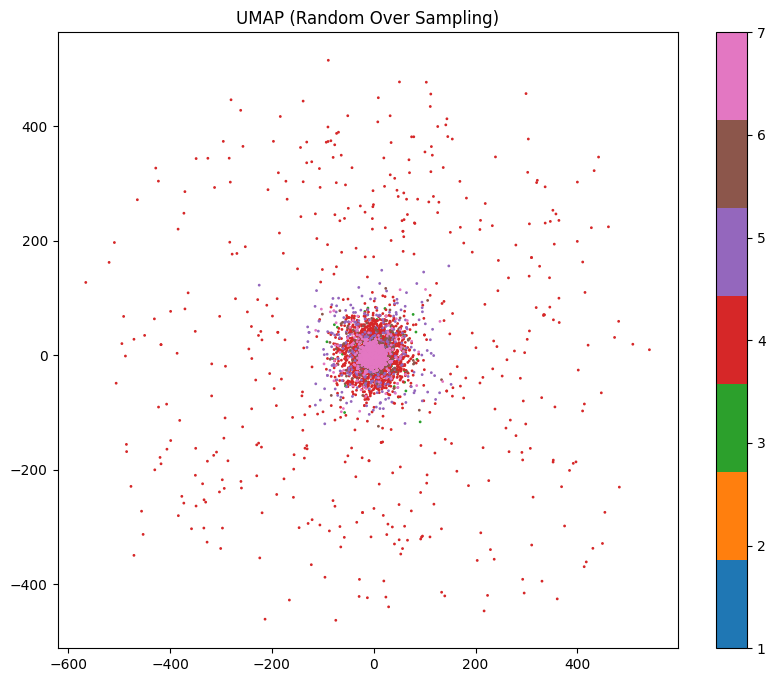

Accuracy: 0.7893
F1-Score: 0.7874

Rapport de classification:
              precision    recall  f1-score   support

           1       0.78      0.74      0.76      1459
           2       0.79      0.84      0.81      1930
           3       0.76      0.88      0.81       241
           4       0.88      0.39      0.54        18
           5       0.68      0.48      0.57        62
           6       0.80      0.62      0.70       133
           7       0.88      0.78      0.83       157

    accuracy                           0.79      4000
   macro avg       0.80      0.68      0.72      4000
weighted avg       0.79      0.79      0.79      4000



In [24]:
visualize_embeddings(X_tsne_ros, y_train_ros, "T-SNE (Random Over Sampling)")
visualize_embeddings(X_umap_ros, y_train_ros, "UMAP (Random Over Sampling)")
evaluate(rfc_ros, X_test_scaled, y_test)

### Adasyn

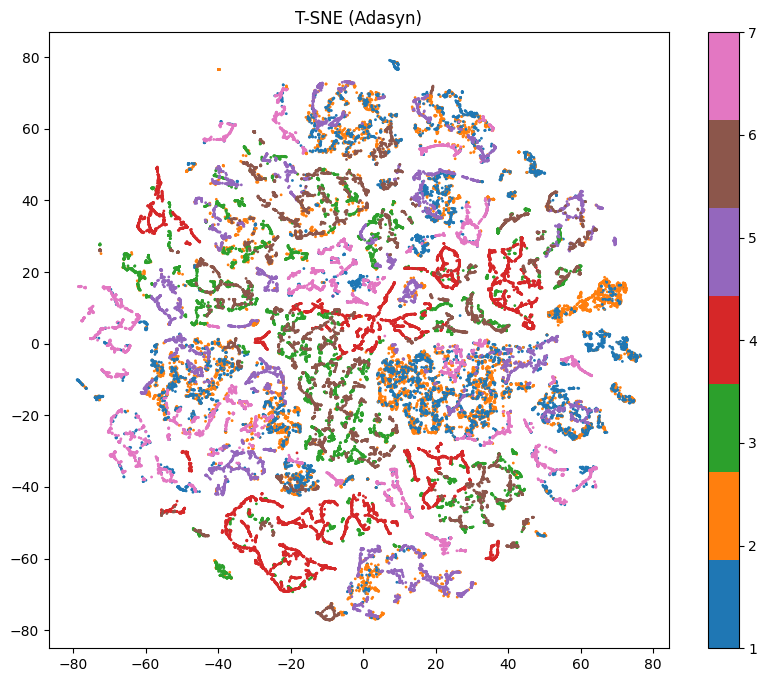

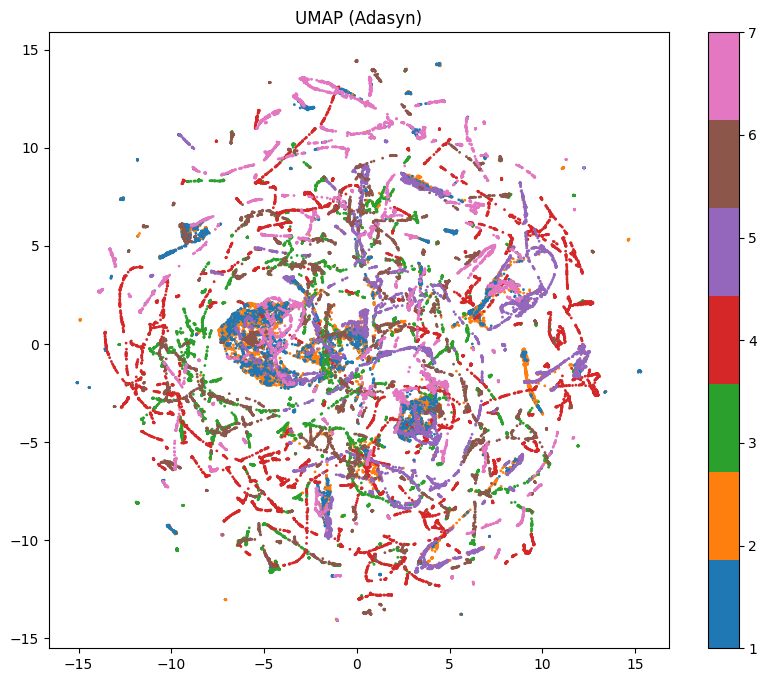

Accuracy: 0.7790
F1-Score: 0.7800

Rapport de classification:
              precision    recall  f1-score   support

           1       0.77      0.77      0.77      1459
           2       0.82      0.78      0.80      1930
           3       0.75      0.89      0.81       241
           4       0.58      0.61      0.59        18
           5       0.45      0.61      0.52        62
           6       0.64      0.71      0.68       133
           7       0.74      0.85      0.79       157

    accuracy                           0.78      4000
   macro avg       0.68      0.75      0.71      4000
weighted avg       0.78      0.78      0.78      4000



In [25]:
visualize_embeddings(X_tsne_adasyn, y_train_adasyn, "T-SNE (Adasyn)")
visualize_embeddings(X_umap_adasyn, y_train_adasyn, "UMAP (Adasyn)")
evaluate(rfc_adasyn, X_test_scaled, y_test)

### Smote

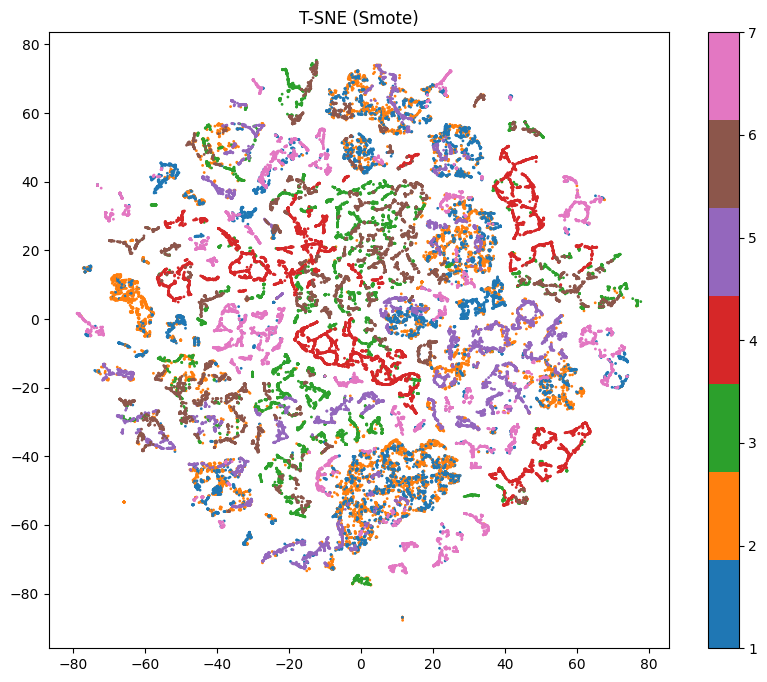

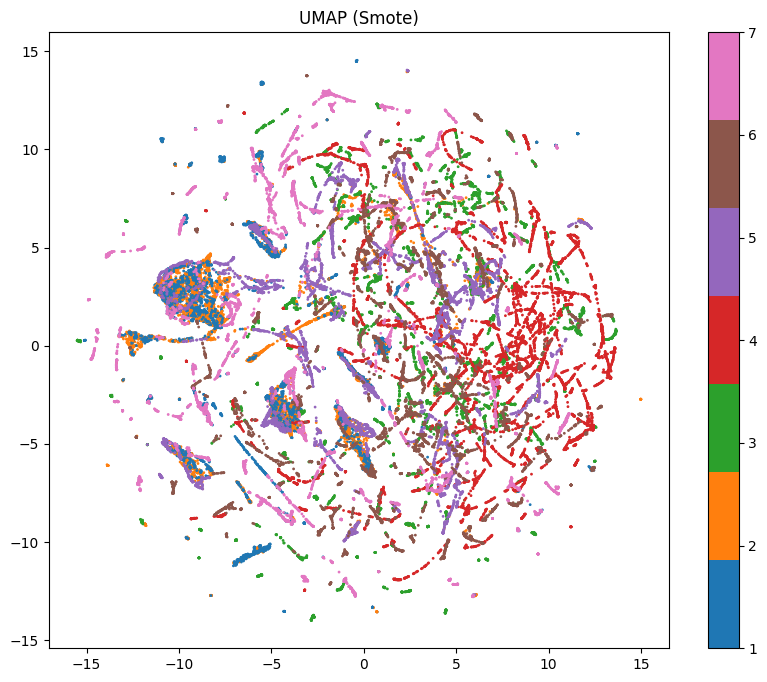

Accuracy: 0.7823
F1-Score: 0.7833

Rapport de classification:
              precision    recall  f1-score   support

           1       0.78      0.75      0.77      1459
           2       0.81      0.80      0.81      1930
           3       0.76      0.87      0.81       241
           4       0.63      0.67      0.65        18
           5       0.43      0.63      0.51        62
           6       0.65      0.73      0.69       133
           7       0.79      0.85      0.82       157

    accuracy                           0.78      4000
   macro avg       0.69      0.76      0.72      4000
weighted avg       0.79      0.78      0.78      4000



In [26]:
visualize_embeddings(X_tsne_smote, y_train_smote, "T-SNE (Smote)")
visualize_embeddings(X_umap_smote, y_train_smote, "UMAP (Smote)")
evaluate(rfc_smote, X_test_scaled, y_test)